In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

In [3]:
subject='sub-001'
MAIN_PATH='/data1/projects/dumoulinlab/Lab_members/Mayra/projects'
project='CFLamUp'
resampling='resampled'
denoising='nordic_sm4'
filter=1

In [68]:
#In case of laminar analysis, we import outputs from pybest in the func space as giftis and have to calculate psc ourselves for each layer. If outputs from pybest are in .npy format, we can run fitprf (master -m 17) from linescanning pipeline and get the psc calculation from the derivatives/prf folder. Therefore, we here reproduce the psc calculation, first in an usual case (non-laminar) where we do have the outputs in the fsnative space as .npy. NOTE: this has been previously checked and will be removed.

# pybest_tc_L = []
# pybest_tc_R = []
# pybest_tc = []
#
# #Get pybest outputs as .npy files and calculate psc:
# for run in range(4):
#     pybest_tc_L = np.load(
#         f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/resampled_surfGM/{subject}/ses-1/unzscored/{subject}_ses-1_task-ret_run-{run + 1}_space-fsnative_hemi-L_desc-denoised_bold.npy')
#     pybest_tc_R = np.load(
#         f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/pybest/{subject}/ses-1/unzscored/{subject}_ses-1_task-ret_run-{run + 1}_space-fsnative_hemi-R_desc-denoised_bold.npy')
#     tc = np.concatenate([pybest_tc_L, pybest_tc_R], axis=1)
#     tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0)
#     baseline = np.median(tc_m[0:19], axis=0)
#     tc_m = tc_m - baseline
#     pybest_tc.append(tc_m)
#
# mean_pybest_tc = np.median(np.array(pybest_tc), axis=0)
# psc = (mean_pybest_tc)

In [69]:
# #get psc as calculated in linescanning pipeline fitprf (master -m 17) in derivatives/prf outputs:
# psc_avg_ts=np.load(f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLam/derivatives/prf/{subject}/ses-1/{subject}_ses-1_task-ret_hemi-LR_desc-avg_bold.npy').T[:,:]
# print(psc_avg_ts.shape)
#
# #Compare pscs:
# i_vx=100 #random vertix
# plt.plot(psc[:, i_vx])
# plt.plot(psc_avg_ts[i_vx, :])
# np.corrcoef(psc[:, i_vx], psc_avg_ts[i_vx, :])

In [4]:
#Now we repeat the calculation for giftis
proc_tc_L = []
proc_tc_R = []
proc_tc = []
depth="GM"

#Get pybest outputs as .npy files and calculate psc:
for run in range(4):
    proc_tc_L = nib.load(
        f'{MAIN_PATH}/{project}/derivatives/{resampling}/{subject}/ses-1/{denoising}/{subject}_ses-1_task-ret_run-{run + 1}_space-fsnative_hemi-L_desc-{denoising}_bold_{depth}.gii')
    proc_tc_R = nib.load(
        f'{MAIN_PATH}/{project}/derivatives/{resampling}/{subject}/ses-1/{denoising}/{subject}_ses-1_task-ret_run-{run + 1}_space-fsnative_hemi-R_desc-{denoising}_bold_{depth}.gii')
    # pybest_tc_L = nib.load(
    #     '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLam/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-ret_run-'f'{run + 1}_space-fsnative_hemi-L_desc-denoised.gii')
    # pybest_tc_R = nib.load(
    #     '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLam/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-ret_run-'f'{run + 1}_space-fsnative_hemi-R_desc-denoised.gii')
    tc = np.vstack([proc_tc_L.agg_data(), proc_tc_R.agg_data()]).T
    if tc.shape[0]>225:
        tc=tc[:225,:]
    tc=tc[5:215,:]
    tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0)
    #do baseline correction
    baseline = np.median(tc_m[:9], axis=0)
    tc_m = tc_m - baseline

    #baseline = np.median(tc_m[0:19], axis=0)
    if filter==1:
        from scipy import signal
        #remove linear trend without demeaning
        mean=np.mean(tc_m, axis=0)
        tc_m=signal.detrend(tc_m, axis=0)+mean
        #do highpass-filtering
        TR = 3
        fs = 1 / TR  # Hz
        lowcut=0.001 # cut-off freq of the filter
        highcut=0.015 # cut-off freq of the filter
        nyquist=0.5*fs
        f_low = lowcut/nyquist;
        f_high = highcut/nyquist;
        sos = signal.butter(8, [f_low],'highpass', fs=fs,output='sos')
        tc_m = signal.sosfiltfilt(sos, tc_m, axis=0)

    proc_tc.append(tc_m)
mean_proc_tc = np.median(np.array(proc_tc), axis=0)
psc = (mean_proc_tc)

/tmp/ipykernel_582686/3192650693.py:21: RuntimeWarning: divide by zero encountered in divide
  tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0)
/tmp/ipykernel_582686/3192650693.py:21: RuntimeWarning: divide by zero encountered in divide
  tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0)


(-6.0, 10.0)

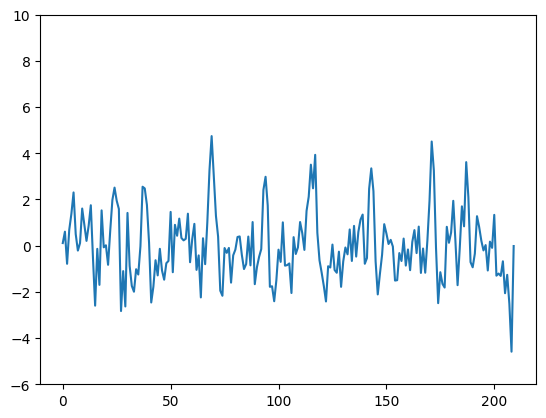

In [5]:
#Compare pscs:
i_vx=2500#random vertex
plt.plot(psc[:, i_vx])
plt.ylim([-6,10])
#plt.plot(psc_avg_ts[i_vx, :])
#np.corrcoef(psc[:, i_vx], psc_avg_ts[i_vx, :])

In [10]:
#mask psc
atlas='benson'
MAIN_PATH=f'/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/{project}/derivatives'
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2']
#rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2','V3a', 'V3b']
import cortex
import cortex.polyutils

#select voxels in selected ROIs

if subject == 'fsaverage':
    fs_dirPATH = '/Volumes/May_fMRI/Inzicht_CFM/derivatives/freesurfer'
else:
    fs_dirPATH = f'{MAIN_PATH}/freesurfer'

# %%
# In order to get the number of vertices in this subject's cortical surface
# we have to load in their surfaces and get the number of points in each
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]
## Mask voxels outside visual cortex based on Benson Atlas for efficiency
# First we need to import the surfaces for this subject
numel_left = surfs[0].pts.shape[0]
numel_right = surfs[1].pts.shape[0]
numel = numel_left + numel_right

idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subject, label='benson14_eccen-0001',
                                                  fs_dir=fs_dirPATH,
                                                  hemisphere=('lh', 'rh'),
                                                  verbose=True)

idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001',
                                                  fs_dir=fs_dirPATH,
                                                  hemisphere=('lh', 'rh'),
                                                  verbose=True)

if atlas == 'manual':
    idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin',
                                                      fs_dir=fs_dirPATH,
                                                      hemisphere=('lh', 'rh'),
                                                      verbose=True)
    idx_vls4[idx_rois5] = idx_vls5

#plot Benson atlas
rois_list = []
rois_list = np.array([['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2'], [1, 2, 3, 4, 7, 8]])
#rois_list = np.array([['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2', 'V3a', 'V3b'], [1, 2, 3, 4, 7, 8, 11, 12]])

rois_mask = cortex.Vertex.empty(subject)
rois_idx = cortex.Vertex.empty(subject)
for r in range(rois.__len__()):
    roi_idx = np.where(rois[r] == rois_list[0, :])
    #roi_verts = np.array(np.where(idx_vls4 == int(rois_list[1, roi_idx])))[0]
    roi_verts = np.where(np.logical_and(idx_vls4 == int(rois_list[1, roi_idx]), idx_vls1 < 15))[0]
    rois_mask.data[roi_verts] = 1
    rois_idx.data[roi_verts] = roi_verts




looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-004/label/lh.benson14_eccen-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-004/label/rh.benson14_eccen-0001.label']
looking for ['/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-004/label/lh.benson14_varea-0001.label', '/Users/mayra/Library/CloudStorage/OneDrive-UMCG/Postdoc/CFLamUp/derivatives/freesurfer/sub-004/label/rh.benson14_varea-0001.label']


(-6.0, 8.0)

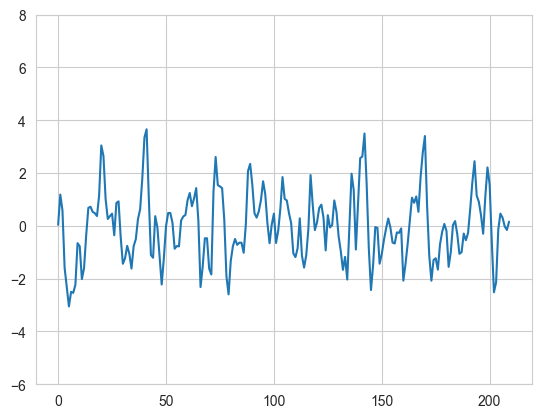

In [50]:
psc=psc.T
psc_avg_ts = psc[rois_mask.data == 1]
psc_avg_ts_vx = rois_idx.data[rois_mask.data == 1]
psc_avg_ts.shape
#Compare pscs:
i_vx=10761#random vertex
plt.plot(psc_avg_ts[i_vx,:])
plt.ylim([-6,8])
#plt.plot(psc_avg_ts[i_vx, :])
#np.corrcoef(psc[:, i_vx], psc_avg_ts[i_vx, :])

In [6]:
path=f'{MAIN_PATH}/{project}/derivatives/pRFM/{subject}/ses-1/{denoising}/'
os.makedirs(path, exist_ok=True)
#np.save("./pilot1-fsnativeWNORDIC_lamGM/fast_fit/sub-001_ses-1_task-ret_hemi-LR_desc-avg_bold_lamGM.npy",psc)
np.save(f'{MAIN_PATH}/{project}/derivatives/pRFM/{subject}/ses-1/{denoising}/{subject}_ses-1_task-ret_hemi-LR_desc-avg_bold_{depth}.npy',psc)